##Libreria

In [ ]:
!pip install tensorflow-addons
!pip install tensorflow===2.14.0

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from scipy.ndimage import zoom
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, Dense, Dropout, Input

In [ ]:
print(tf.__version__)

2.14.0


In [ ]:
print(sys.version)

3.10.12 (main, Jul 29 2024, 16:56:48) [GCC 11.4.0]


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##Carga de datos

In [ ]:
classes=["AD","bvFTD","HC"]

In [ ]:
AD =np.load("/content/drive/MyDrive/BrainLat/EEGIMG/1_AD/stft.npy")#ad
BV =np.load("/content/drive/MyDrive/BrainLat/EEGIMG/2_bvFTD/stft.npy")#bv
HC =np.load("/content/drive/MyDrive/BrainLat/EEGIMG/5_HC/stft.npy")#hc

## Load Model

In [ ]:
model=load_model("/content/drive/MyDrive/BrainLat/Experimentos/Cross_Val_3_class_42_random_state.hdf5")
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 128)]      0         []                            
                                                                                                  
 conv2d_1 (Conv2D)           (None, 112, 112, 64)         73792     ['input_1[0][0]']             
                                                                                                  
 batch_normalization_1 (Bat  (None, 112, 112, 64)         256       ['conv2d_1[0][0]']            
 chNormalization)                                                                                 
                                                                                                  
 re_lu (ReLU)                (None, 112, 112, 64)         0         ['batch_normalization_1[0]

##Grad-Cam

In [ ]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    """Generate class activation heatmap"""

    # Create a model that maps the input image to the activations of the last convolutional layer
    # and the output predictions
    grad_model = Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Compute the gradient of the top predicted class for the input image
    # with respect to the activations of the last convolutional layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        # If pred_index is not provided, use the index of the top predicted class
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # Compute the gradient of the output neuron (top predicted or chosen)
    # with respect to the output feature map of the last convolutional layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # Compute the mean intensity of the gradient over each channel in the feature map
    # This is equivalent to global average pooling
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Multiply each channel in the feature map array by 'how important this channel is'
    # with respect to the top predicted class, then sum all the channels to obtain the heatmap
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = tf.multiply(pooled_grads, last_conv_layer_output)

    # Normalize the heatmap between 0 & 1 for visualization
    # Clipping values to be non-negative, equivalent to applying ReLU
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def get_resized_heatmap(heatmap, shape):
    """Resize heatmap to match the shape of the original image"""
    # Rescale heatmap to a range 0-255 for visualization
    upscaled_heatmap = np.uint8(255 * heatmap)

    # Resize the heatmap to match the dimensions of the original image
    upscaled_heatmap = zoom(
        upscaled_heatmap,
        (
            shape[0] / upscaled_heatmap.shape[0],
            shape[1] / upscaled_heatmap.shape[1],
            shape[2] / upscaled_heatmap.shape[2],
        ),
    )
    return upscaled_heatmap


## Grad-Cam per class

In [ ]:
last_conv_layer_name = "conv2d_13"

def compute_gradcam_for_class(images, model, last_conv_layer_name):
    """
    Compute Grad-CAM heatmaps for a list of images.

    Parameters:
    images (list or np.array): List or array of images for which to compute the Grad-CAM heatmaps.
    model (tf.keras.Model): The model used for generating the Grad-CAM heatmaps.
    last_conv_layer_name (str): The name of the last convolutional layer in the model.

    Returns:
    np.array: Array of Grad-CAM heatmaps corresponding to the input images.
    """
    gradcam_images = []
    for img in images:
        # Expand dimensions to match the model input shape (batch size, height, width, channels)
        img_array = np.expand_dims(img, axis=0)

        # Generate Grad-CAM heatmap for the current image
        heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

        # Resize the heatmap to match the dimensions of the input image
        resized_heatmap = get_resized_heatmap(heatmap, img.shape)

        # Append the resized heatmap to the list of Grad-CAM images
        gradcam_images.append(resized_heatmap)

    # Convert list of Grad-CAM heatmaps to a NumPy array
    return np.array(gradcam_images)

# Calculate Grad-CAM for each class
gradcam_AD = compute_gradcam_for_class(AD, model, last_conv_layer_name)
gradcam_BV = compute_gradcam_for_class(BV, model, last_conv_layer_name)
gradcam_HC = compute_gradcam_for_class(HC, model, last_conv_layer_name)

# Verify the dimensions of the Grad-CAM heatmaps for each class
print(f'AD Grad-CAM shape: {gradcam_AD.shape}')
print(f'BV Grad-CAM shape: {gradcam_BV.shape}')
print(f'HC Grad-CAM shape: {gradcam_HC.shape}')

In [ ]:
# Compute the average Grad-CAM for each class
gradcam_AD_avg = np.mean(gradcam_AD, axis=0)
gradcam_BV_avg = np.mean(gradcam_BV, axis=0)
gradcam_HC_avg = np.mean(gradcam_HC, axis=0)

# Verify the dimensions of the average Grad-CAM
print(f'AD Average Grad-CAM shape: {gradcam_AD_avg.shape}')
print(f'BV Average Grad-CAM shape: {gradcam_BV_avg.shape}')
print(f'HC Average Grad-CAM shape: {gradcam_HC_avg.shape}')

# Sum of pixel values for each layer in the average Grad-CAM for each class
sum_pixels_AD = np.sum(gradcam_AD_avg, axis=(0, 1))
sum_pixels_BV = np.sum(gradcam_BV_avg, axis=(0, 1))
sum_pixels_HC = np.sum(gradcam_HC_avg, axis=(0, 1))

# Find the layer with the highest pixel sum for each class
max_layer_AD = np.argmax(sum_pixels_AD)
max_layer_BV = np.argmax(sum_pixels_BV)
max_layer_HC = np.argmax(sum_pixels_HC)

# Visualization of the results
print(f'For AD, the layer with the highest pixel intensity is number: {max_layer_AD}')
print(f'For BV, the layer with the highest pixel intensity is number: {max_layer_BV}')
print(f'For HC, the layer with the highest pixel intensity is number: {max_layer_HC}')

Para AD, la capa con más intensidad de píxeles es la número: 19
Para BV, la capa con más intensidad de píxeles es la número: 1
Para HC, la capa con más intensidad de píxeles es la número: 117


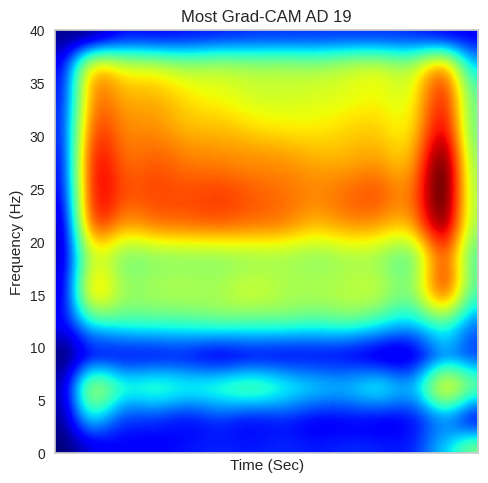

In [ ]:
y_range = (0, 40)
x_range = (0, 40)
plt.imshow(gradcam_AD_avg[:,:,19], cmap='jet', extent=[x_range[0], x_range[1],y_range[0], y_range[1]])
plt.xlabel('Time (Sec)')
plt.ylabel('Frequency (Hz)')
plt.xlim(x_range)
plt.ylim(y_range)
plt.grid(False)
plt.xticks([])
plt.title('Most Grad-CAM AD 19')
plt.show()

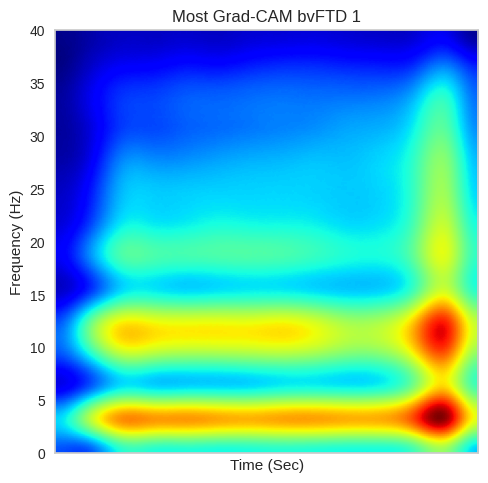

In [ ]:
y_range = (0, 40)
x_range = (0, 40)
plt.imshow(gradcam_BV_avg[:,:,1], cmap='jet', extent=[x_range[0], x_range[1],y_range[0], y_range[1]])
plt.xlabel('Time (Sec)')
plt.ylabel('Frequency (Hz)')
plt.xlim(x_range)
plt.ylim(y_range)
plt.grid(False)
plt.xticks([])
plt.title('Most Grad-CAM bvFTD 1')
plt.show()

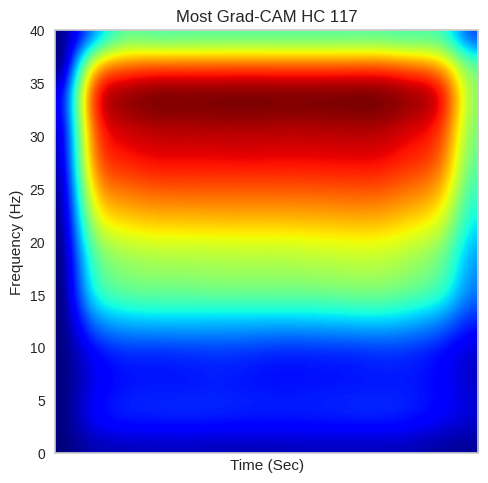

In [ ]:
y_range = (0, 40)
x_range = (0, 40)
plt.imshow(gradcam_HC_avg[:, :, 117], cmap='jet', extent=[x_range[0], x_range[1],y_range[0], y_range[1]])
plt.xlabel('Time (Sec)')
plt.ylabel('Frequency (Hz)')
plt.xlim(x_range)
plt.ylim(y_range)
plt.grid(False)
plt.xticks([])
plt.title('Most Grad-CAM HC 117')
plt.show()

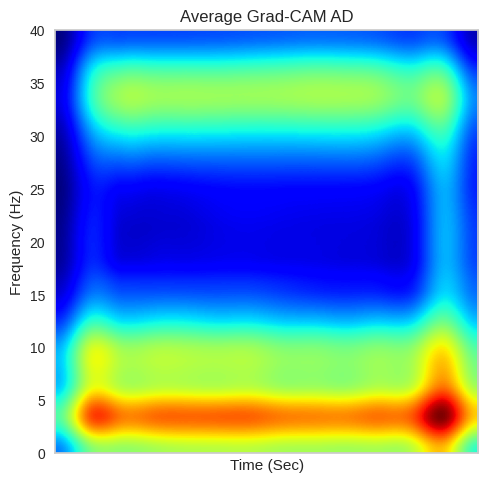

In [ ]:
summed_gradcam = np.sum(gradcam_AD_avg, axis=2)
# Divide the resulting image by 128 to obtain the average.
average_gradcam = summed_gradcam / 128

# Verification of the dimensions of the resulting image
assert average_gradcam.shape == (224, 224), "The average image dimension does not match the expected one".
y_range = (0, 40)
x_range = (0, 40)
plt.imshow(average_gradcam, cmap='jet', extent=[x_range[0], x_range[1],y_range[0], y_range[1]])
plt.xlabel('Time (Sec)')
plt.ylabel('Frequency (Hz)')
plt.xlim(x_range)
plt.ylim(y_range)
plt.grid(False)
plt.xticks([])
plt.title('Average Grad-CAM AD')
plt.show()

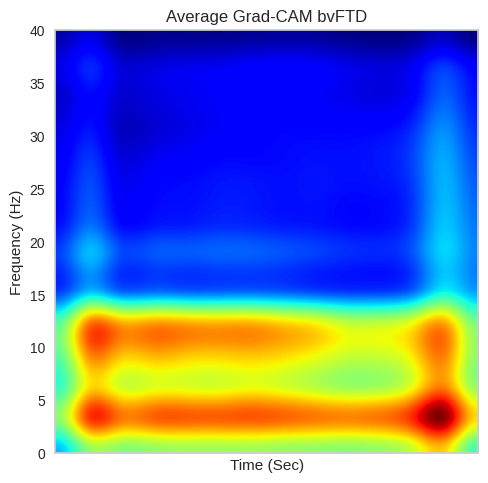

In [ ]:
summed_gradcam = np.sum(gradcam_BV_avg, axis=2)
# Divide the resulting image by 128 to obtain the average.
average_gradcam = summed_gradcam / 128

# Verification of the dimensions of the resulting image
assert average_gradcam.shape == (224, 224), "The average image dimension does not match the expected one".
y_range = (0, 40)
x_range = (0, 40)
plt.imshow(average_gradcam, cmap='jet', extent=[x_range[0], x_range[1],y_range[0], y_range[1]])
plt.xlabel('Time (Sec)')
plt.ylabel('Frequency (Hz)')
plt.xlim(x_range)
plt.ylim(y_range)
plt.grid(False)
plt.xticks([])
plt.title('Average Grad-CAM bvFTD')
plt.show()

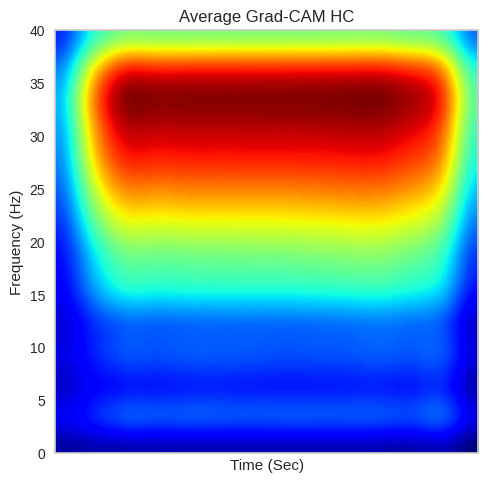

In [ ]:
summed_gradcam = np.sum(gradcam_HC_avg, axis=2)
# Divide the resulting image by 128 to obtain the average.
average_gradcam = summed_gradcam / 128

# Verification of the dimensions of the resulting image
assert average_gradcam.shape == (224, 224), "The average image dimension does not match the expected one".
y_range = (0, 40)
x_range = (0, 40)
plt.imshow(average_gradcam, cmap='jet', extent=[x_range[0], x_range[1],y_range[0], y_range[1]])
plt.xlabel('Time (Sec)')
plt.ylabel('Frequency (Hz)')
plt.xlim(x_range)
plt.ylim(y_range)
plt.grid(False)
plt.xticks([])
plt.title('Average Grad-CAM HC')
plt.show()

## Grad Cam for each convolutional layer

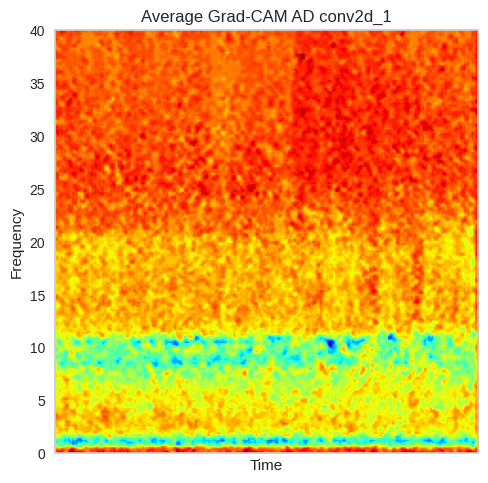

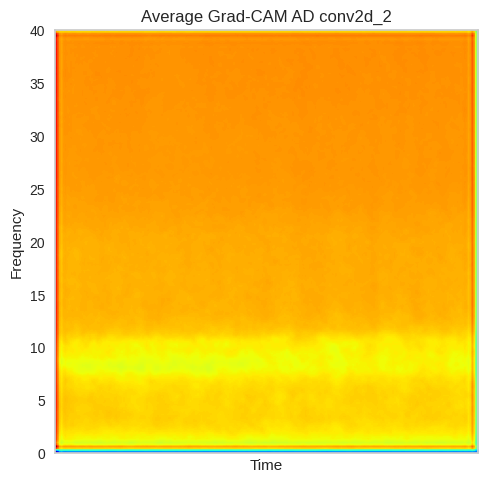

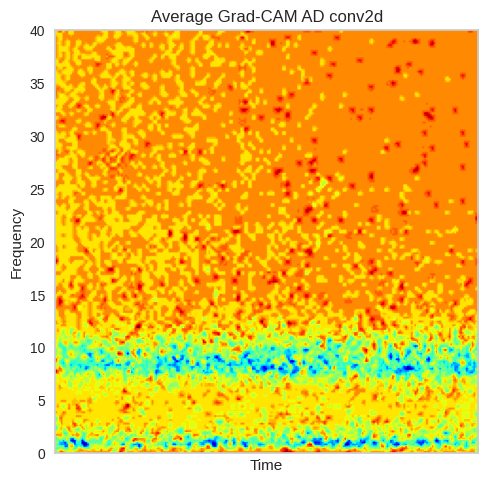

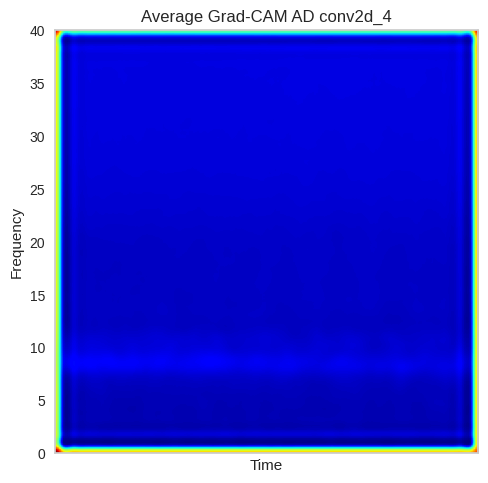

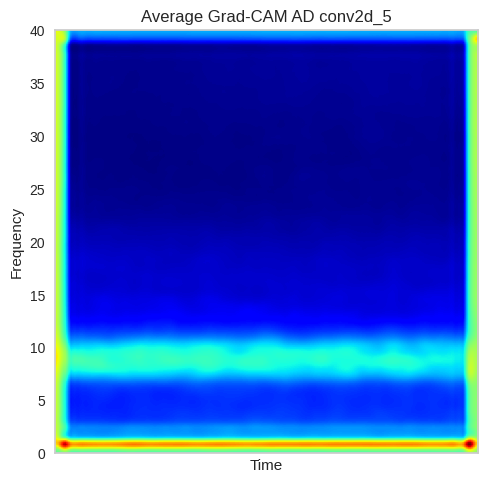

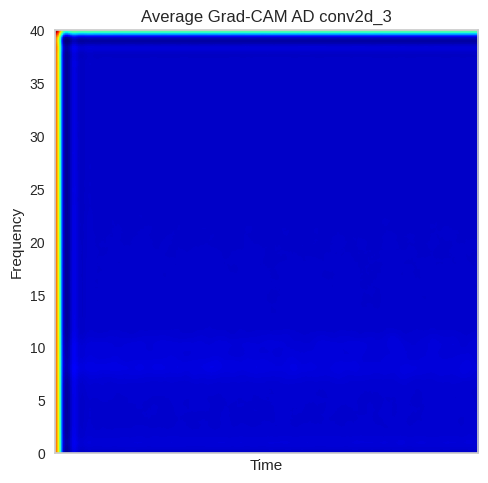

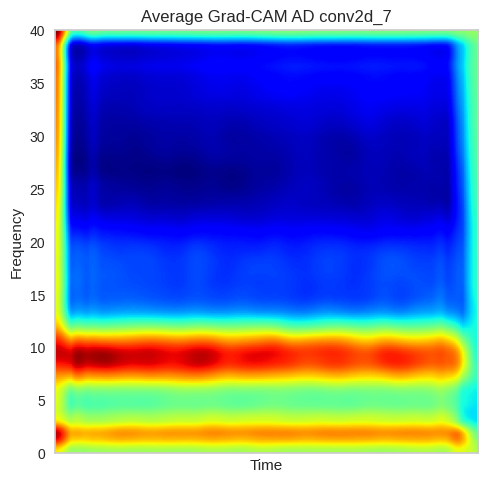

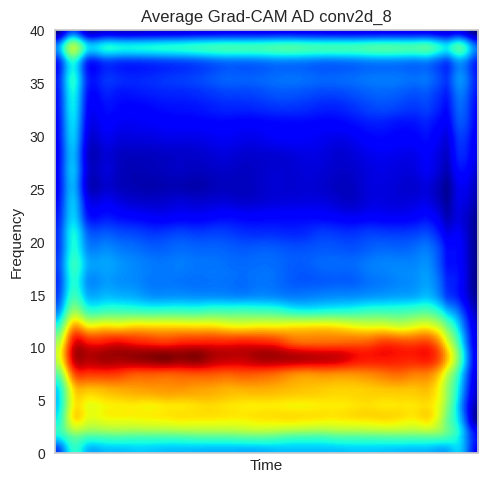

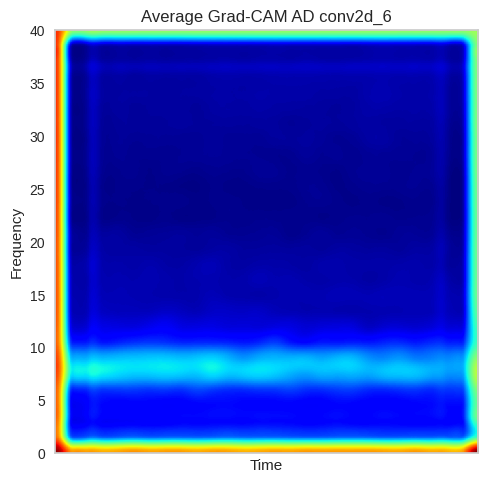

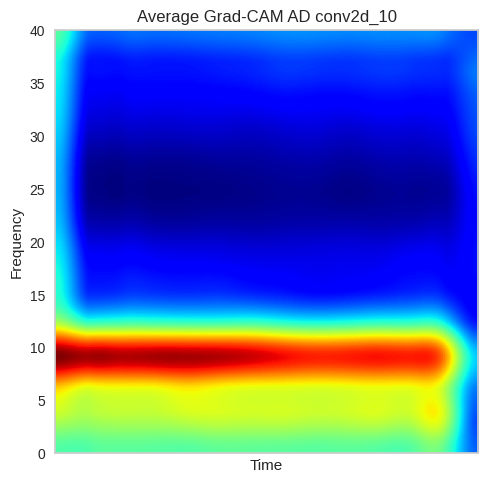

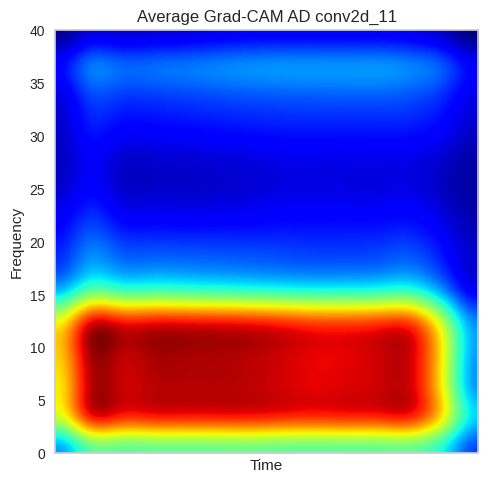

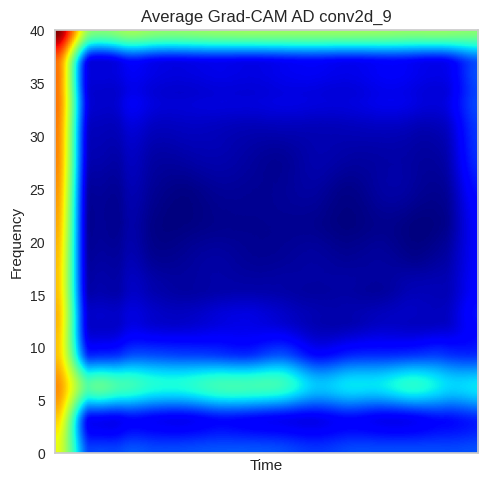

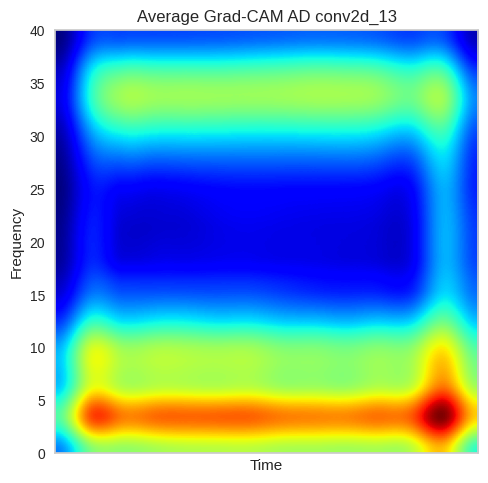

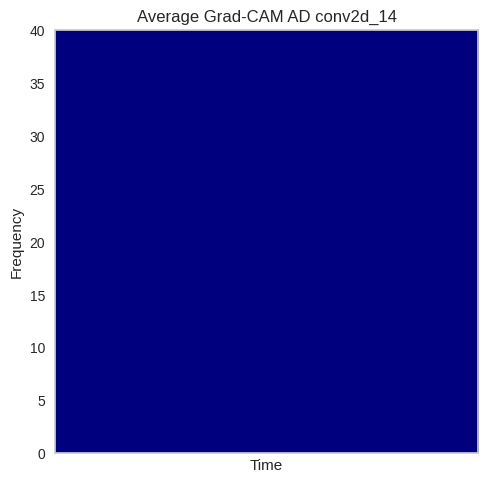

In [ ]:
conv_layers = ["conv2d_1", "conv2d_2", "conv2d", "conv2d_4", "conv2d_5", "conv2d_3", "conv2d_7", "conv2d_8", "conv2d_6", "conv2d_10", "conv2d_11", "conv2d_9", "conv2d_13", "conv2d_14"]

def compute_gradcam_for_class(images, model, last_conv_layer_name):
    gradcam_images = []
    for img in images:
        img_array = np.expand_dims(img, axis=0)
        heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
        resized_heatmap = get_resized_heatmap(heatmap, img.shape)
        gradcam_images.append(resized_heatmap)
    return np.array(gradcam_images)

for i in conv_layers:
  # Compute Grad-CAM for each class
  gradcam_AD = compute_gradcam_for_class(AD, model, i)

  # Compute average Grad-CAM for each class
  gradcam_AD_avg = np.mean(gradcam_AD, axis=0)

  # Sum the Grad-CAM values along the channel axis
  summed_gradcam = np.sum(gradcam_AD_avg, axis=2)

  # Divide the resulting image by 128 to get the average
  average_gradcam = summed_gradcam / 128

  # Verify the dimensions of the resulting image
  assert average_gradcam.shape == (224, 224), "The dimension of the average image does not match the expected size"

  y_range = (0, 40)
  x_range = (0, 40)

  # Plot the average Grad-CAM
  plt.imshow(average_gradcam, cmap='jet', extent=[x_range[0], x_range[1], y_range[0], y_range[1]])
  plt.xlabel('Time')
  plt.ylabel('Frequency')
  plt.xlim(x_range)
  plt.ylim(y_range)
  plt.grid(False)
  plt.xticks([])
  plt.title('Average Grad-CAM AD ' + i)

  # Save the plot to a PDF file
  plt.savefig("/content/drive/MyDrive/BrainLat/EEGIMG/1_AD/Average_AD_" + i + ".pdf")
  plt.show()

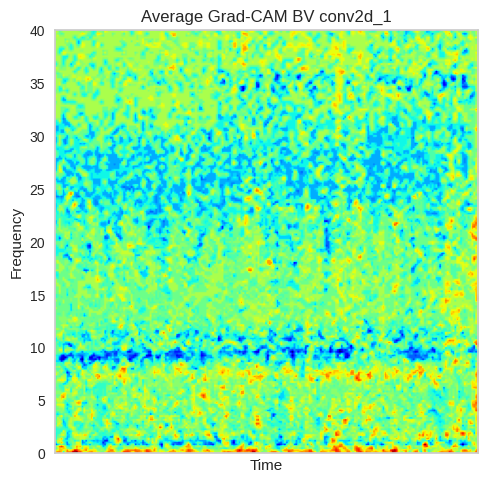

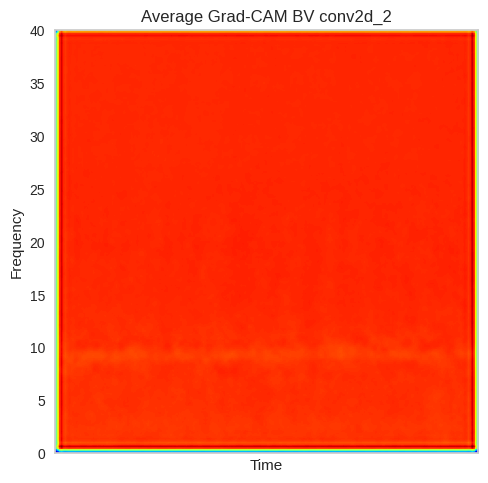

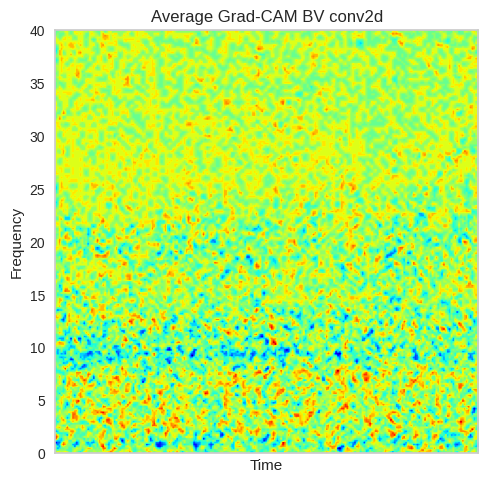

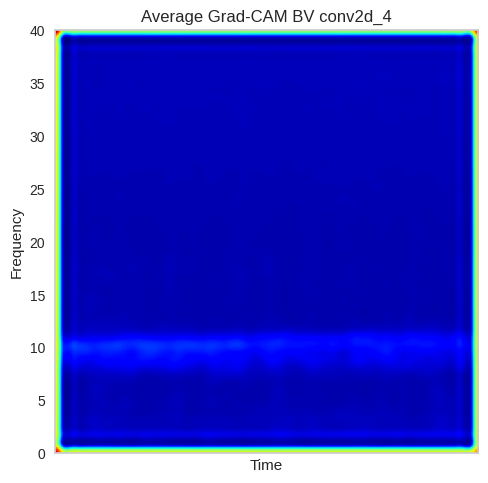

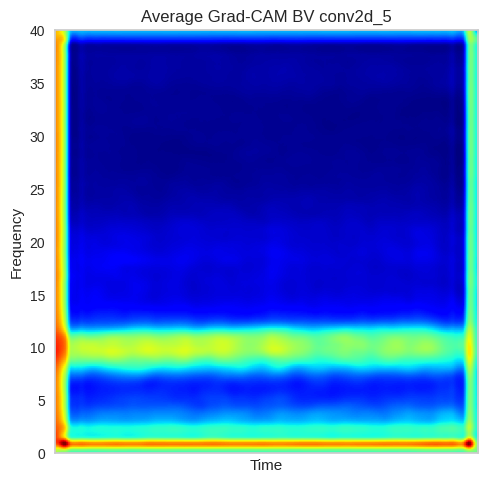

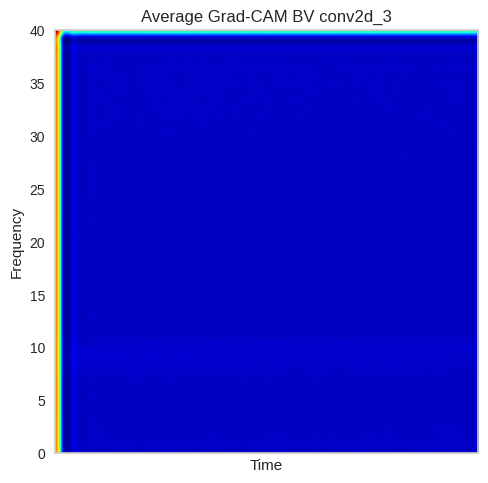

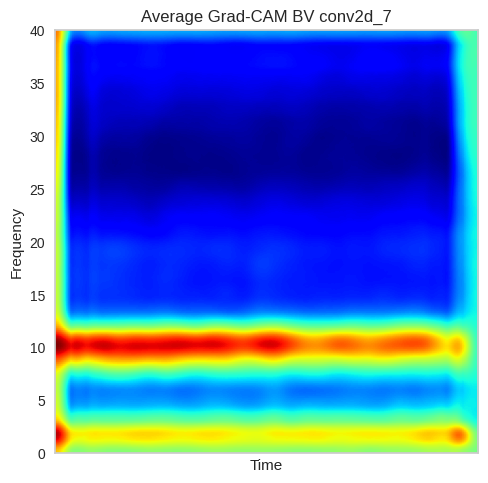

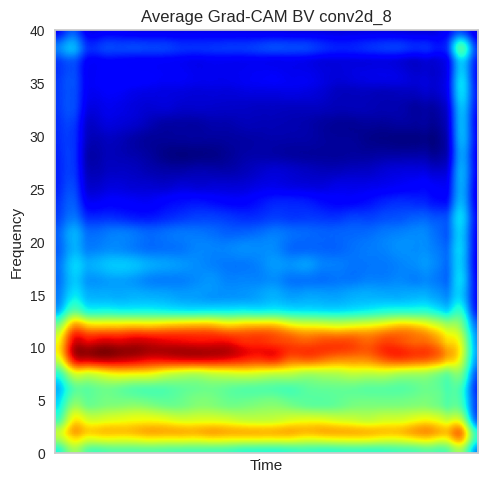

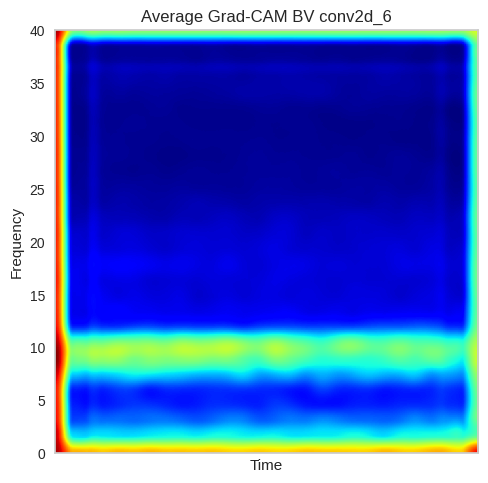

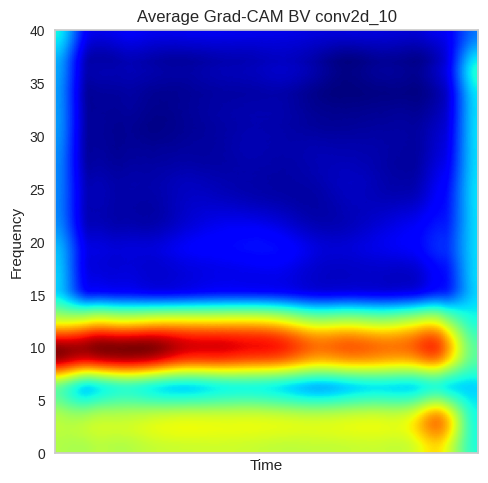

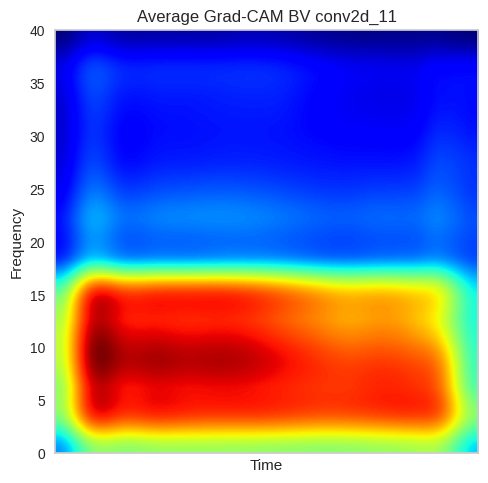

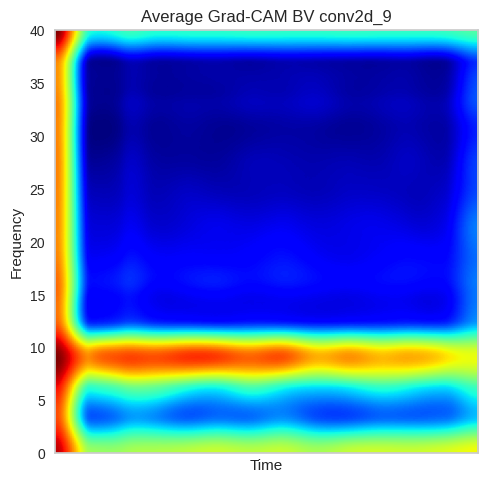

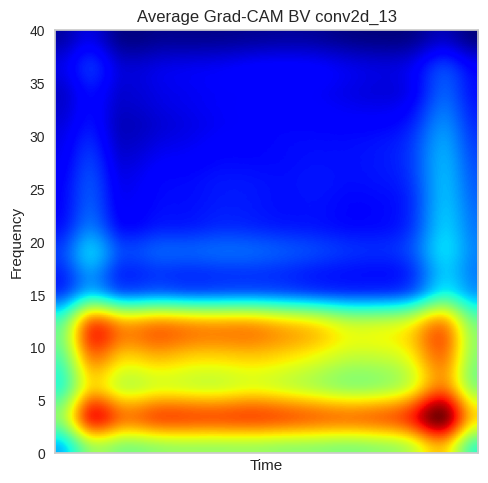

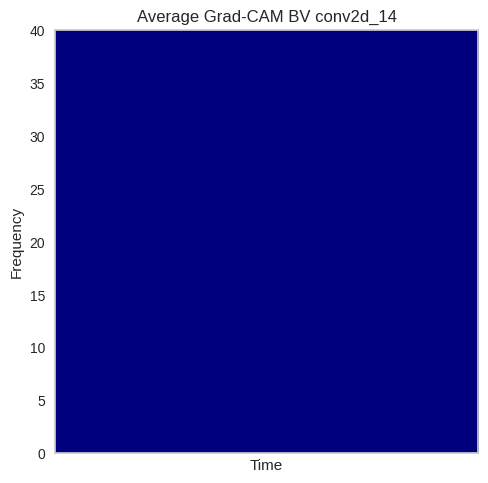

In [ ]:
conv_layers = ["conv2d_1", "conv2d_2", "conv2d", "conv2d_4", "conv2d_5", "conv2d_3", "conv2d_7", "conv2d_8", "conv2d_6", "conv2d_10", "conv2d_11", "conv2d_9", "conv2d_13", "conv2d_14"]

def compute_gradcam_for_class(images, model, last_conv_layer_name):
    gradcam_images = []
    for img in images:
        img_array = np.expand_dims(img, axis=0)
        heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
        resized_heatmap = get_resized_heatmap(heatmap, img.shape)
        gradcam_images.append(resized_heatmap)
    return np.array(gradcam_images)

for i in conv_layers:
    # Compute Grad-CAM for each class
    gradcam_BV = compute_gradcam_for_class(BV, model, i)

    # Compute average Grad-CAM for each class
    gradcam_BV_avg = np.mean(gradcam_BV, axis=0)

    # Sum the Grad-CAM values along the channel axis
    summed_gradcam = np.sum(gradcam_BV_avg, axis=2)

    # Divide the resulting image by 128 to get the average
    average_gradcam = summed_gradcam / 128

    # Verify the dimensions of the resulting image
    assert average_gradcam.shape == (224, 224), "The dimension of the average image does not match the expected size"

    y_range = (0, 40)
    x_range = (0, 40)

    # Plot the average Grad-CAM
    plt.imshow(average_gradcam, cmap='jet', extent=[x_range[0], x_range[1], y_range[0], y_range[1]])
    plt.xlabel('Time')
    plt.ylabel('Frequency')
    plt.xlim(x_range)
    plt.ylim(y_range)
    plt.grid(False)
    plt.xticks([])
    plt.title('Average Grad-CAM BV ' + i)

    # Save the plot to a PDF file
    plt.savefig("/content/drive/MyDrive/BrainLat/EEGIMG/2_bvFTD/Average_BV_" + i + ".pdf")
    plt.show()

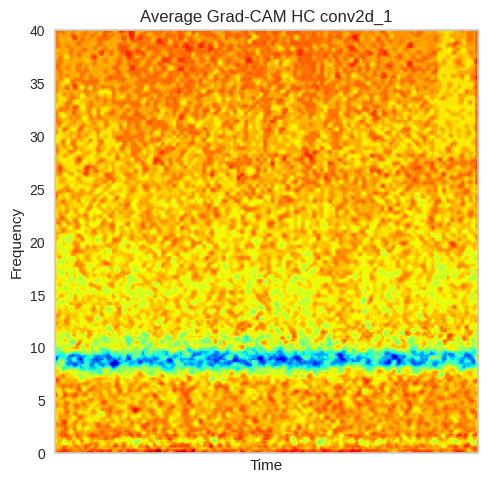

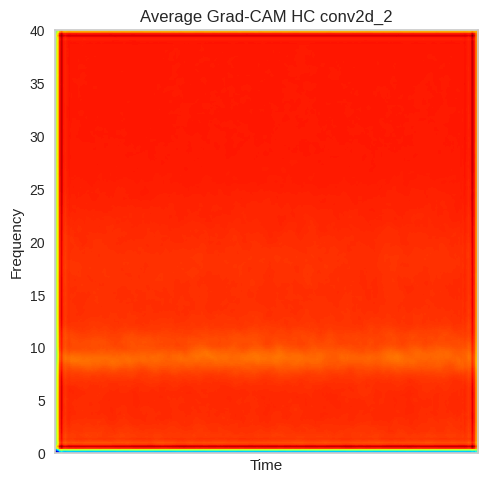

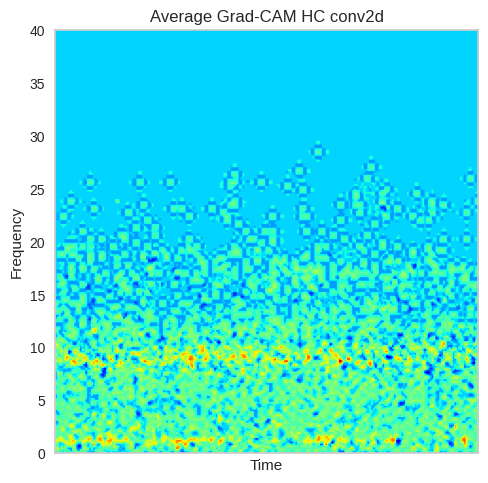

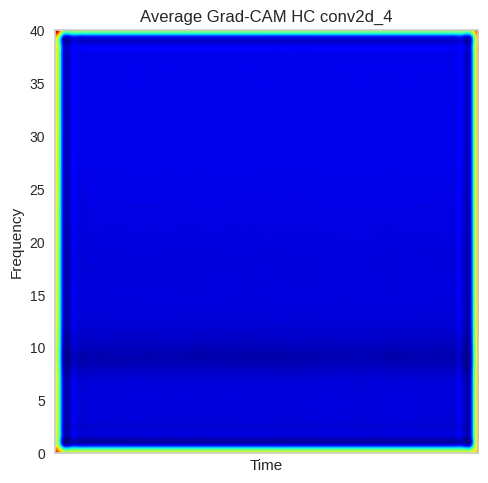

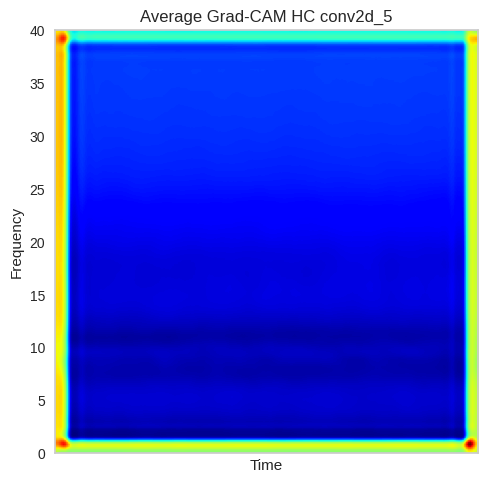

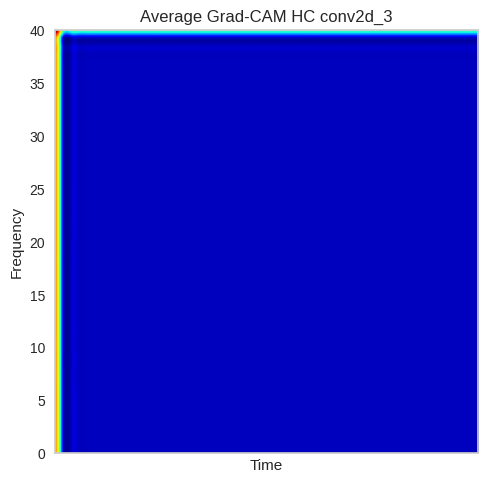

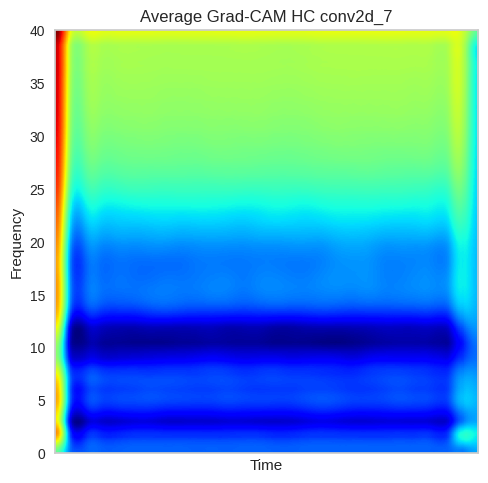

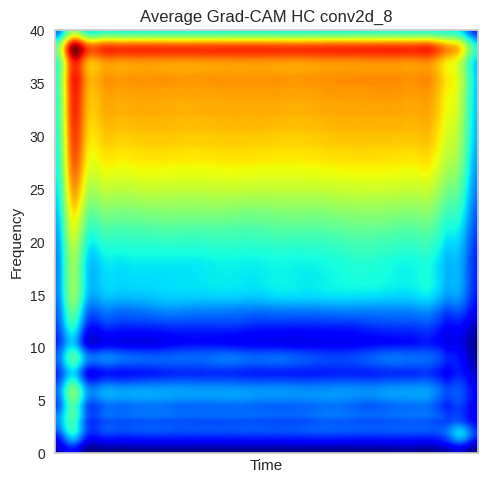

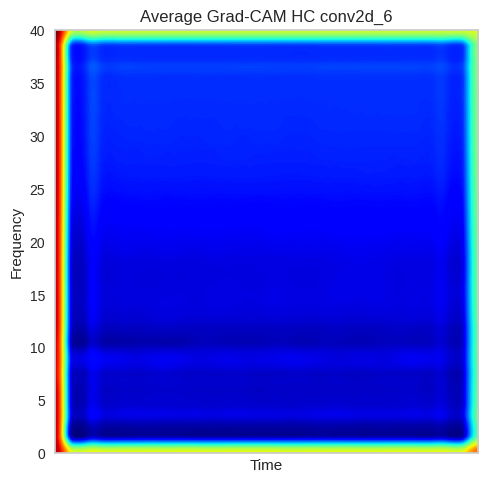

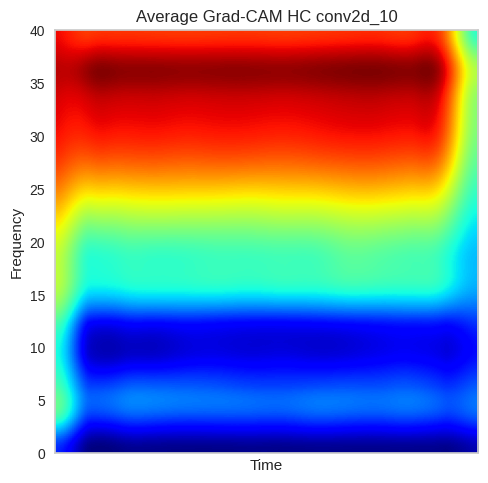

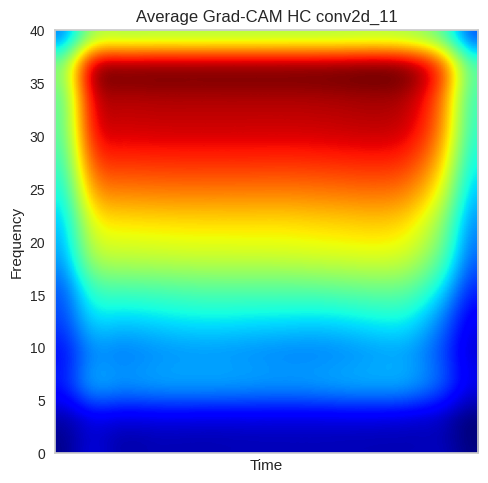

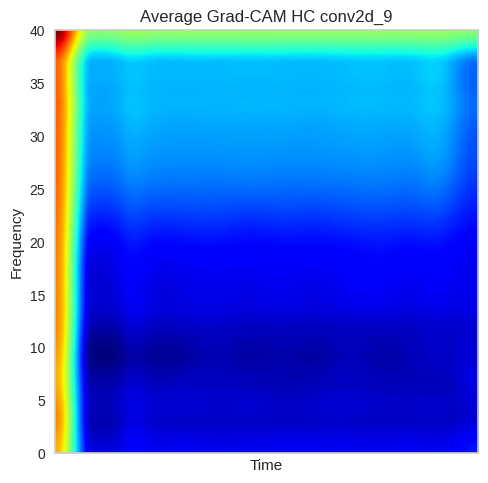

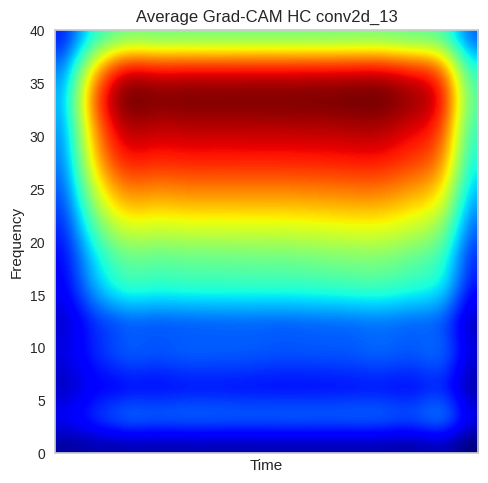

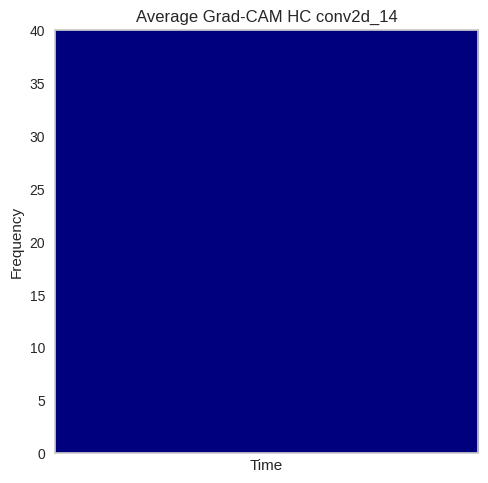

In [ ]:
conv_layers = ["conv2d_1", "conv2d_2", "conv2d", "conv2d_4", "conv2d_5", "conv2d_3", "conv2d_7", "conv2d_8", "conv2d_6", "conv2d_10", "conv2d_11", "conv2d_9", "conv2d_13", "conv2d_14"]

def compute_gradcam_for_class(images, model, last_conv_layer_name):
    gradcam_images = []
    for img in images:
        img_array = np.expand_dims(img, axis=0)
        heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
        resized_heatmap = get_resized_heatmap(heatmap, img.shape)
        gradcam_images.append(resized_heatmap)
    return np.array(gradcam_images)

for i in conv_layers:
    # Compute Grad-CAM for each class
    gradcam_HC = compute_gradcam_for_class(HC, model, i)

    # Compute average Grad-CAM for each class
    gradcam_HC_avg = np.mean(gradcam_HC, axis=0)

    # Sum the Grad-CAM values along the channel axis
    summed_gradcam = np.sum(gradcam_HC_avg, axis=2)

    # Divide the resulting image by 128 to get the average
    average_gradcam = summed_gradcam / 128

    # Verify the dimensions of the resulting image
    assert average_gradcam.shape == (224, 224), "The dimension of the average image does not match the expected size"

    y_range = (0, 40)
    x_range = (0, 40)

    # Plot the average Grad-CAM
    plt.imshow(average_gradcam, cmap='jet', extent=[x_range[0], x_range[1], y_range[0], y_range[1]])
    plt.xlabel('Time')
    plt.ylabel('Frequency')
    plt.xlim(x_range)
    plt.ylim(y_range)
    plt.grid(False)
    plt.xticks([])
    plt.title('Average Grad-CAM HC ' + i)

    # Save the plot to a PDF file
    plt.savefig("/content/drive/MyDrive/BrainLat/EEGIMG/5_HC/Average_HC_" + i + ".pdf")
    plt.show()


## Grad-Cam for map attention

In [ ]:
def compute_gradcam_for_class(images, model, last_conv_layer_name):
    gradcam_images = []
    for img in images:
        img_array = np.expand_dims(img, axis=0)
        # Generate class activation heatmap
        heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
        gradcam_images.append(heatmap)
    return np.array(gradcam_images)

# Compute Grad-CAM for the AD class using the specified convolutional layer
gradcam_AD = compute_gradcam_for_class(AD, model, 'multi_head_attention_3')

# Compute the average Grad-CAM for the AD class
# Squeeze the array to remove single-dimensional entries and compute the mean
gradcam_AD_avg = np.nanmean(np.squeeze(gradcam_AD), axis=0)

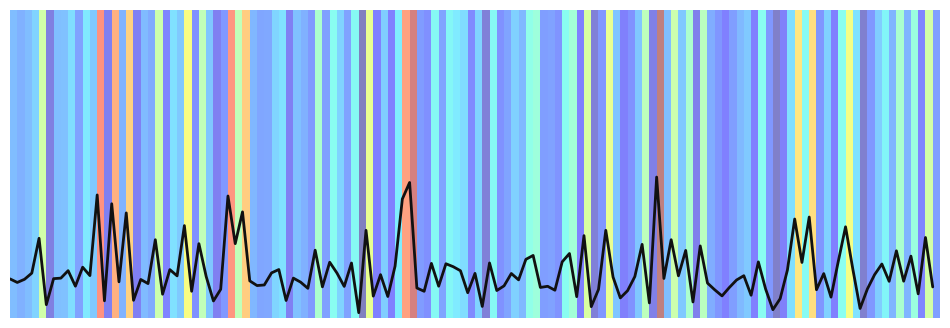

In [ ]:
# Create a matrix for the heatmap by tiling the average Grad-CAM heatmap
heatmap = gradcam_AD_avg
heatmap_matrix = np.tile(heatmap, (100, 1))

# Create the figure and axis
fig, ax = plt.subplots(figsize=(12, 4))

# Plot the heatmap as an image
cax = ax.imshow(heatmap_matrix, aspect='auto', cmap='jet', extent=[0, len(heatmap), 0, 1], alpha=0.5)

# Overlay the line plot of the average Grad-CAM heatmap
ax.plot(range(len(heatmap)), heatmap, color='k', linewidth=2)

# Remove axis and grid
plt.axis("off")
plt.grid(False)

# Save the plot as a PDF file
plt.savefig("/content/drive/MyDrive/BrainLat/EEGIMG/1_AD/Average_AD_Map_Attention_.pdf")

# Display the plot
plt.show()

## Graph of Tokenization

In [ ]:
def compute_gradcam(images, model, last_conv_layer_name):
    gradcam_images = []
    for img in images:
        img_array = np.expand_dims(img, axis=0)
        heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
        # resized_heatmap = get_resized_heatmap(heatmap, img.shape)
        gradcam_images.append(heatmap)
    return np.array(gradcam_images)

In [ ]:
gradcam_AD = compute_gradcam(AD, model,"conv2d_13")

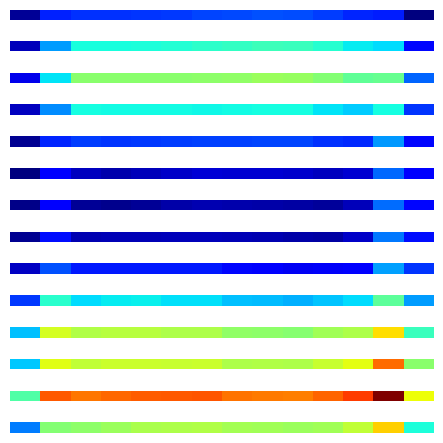

In [ ]:
# Compute the average Grad-CAM for each class
gradcam_AD_avg = np.mean(gradcam_AD, axis=0)  # Calculate the mean of Grad-CAMs across images
summed_gradcam = np.sum(gradcam_AD_avg, axis=2)  # Sum across the channel dimension
# Divide the resulting image by 128 to get the average
average_gradcam = summed_gradcam / 128

# Create a new array of shape (14*3-2, 14) to include two blank rows between each original row
new_shape = (average_gradcam.shape[0] * 3 - 2, average_gradcam.shape[1])
average_gradcam_with_blanks = np.full(new_shape, np.nan)  # Initialize with NaNs

# Copy the original rows to the correct positions in the new array
average_gradcam_with_blanks[::3] = average_gradcam

# Plot the new array with blank rows
y_range = (0, 40)
x_range = (0, 40)
plt.imshow(average_gradcam_with_blanks, cmap='jet', extent=[x_range[0], x_range[1], y_range[0], y_range[1]])
plt.axis("off")  # Turn off axis
plt.grid(False)  # Turn off grid
plt.xticks([])  # Remove x-ticks
plt.show()  # Display the plot

## Parametros vs Accuracy

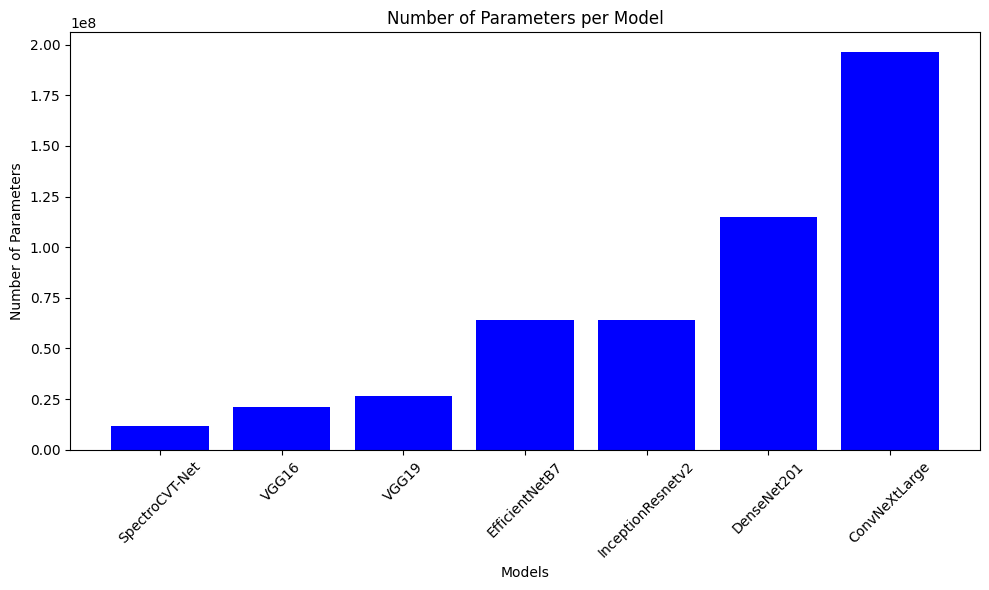

In [ ]:
# Provided data
Models = ['SpectroCVT-Net', 'VGG16', 'VGG19', 'DenseNet201', 'EfficientNetB7', 'ConvNeXtLarge', 'InceptionResnetv2']
Parametros = [11829975, 21244291, 26553987, 115086979, 64105757, 196235334, 64238211]
AccuracyMean = [0.9259259, 0.355555555555555, 0.355555555555555, 0.288888888888888, 0.388888888888888, 0.388888888888888, 0.28888884]

# Package the data into a list of tuples and sort them by the number of parameters
datos_ordenados = sorted(zip(Parametros, Models, AccuracyMean))

# Unpack the sorted data
Parametros_ordenados, Models_ordenados, AccuracyMean_ordenados = zip(*datos_ordenados)

# Create a histogram of the number of parameters
plt.figure(figsize=(10, 6))  # Set the figure size
plt.bar(Models_ordenados, Parametros_ordenados, color='blue')  # Create a bar chart
plt.xlabel('Models')  # Label for the x-axis
plt.ylabel('Number of Parameters')  # Label for the y-axis
plt.title('Number of Parameters per Model')  # Title of the plot
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust the layout to make room for labels
plt.savefig("Parameters.pdf")  # Save the plot as a PDF file
plt.show()  # Display the plot